In [17]:
import keras
import keras.utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D



In [ ]:
random_seed = np.random.seed(2)

In [18]:
train = pd.read_csv('.../train.csv')
print(train.shape)
print(train.head())

(42000, 785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0      

In [19]:
test= pd.read_csv('.../test.csv')
print(test.shape)
print(test.head())

(28000, 784)
   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0

In [20]:
X_train = train.drop(['label'],axis=1)
y_train = train['label']


print(X_train.shape)
print(y_train.shape)

(42000, 784)
(42000,)


[1 0 4 7 3 5 8 9 2 6]
1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64


<AxesSubplot:xlabel='label', ylabel='Count'>

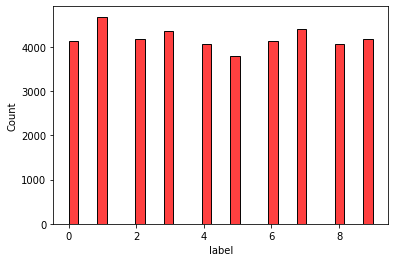

In [21]:
print(y_train.unique())
print(y_train.value_counts(normalize=True))

sns.histplot(y_train,color='red')

Checking data for null or missing values

In [22]:
print(X_train.isnull().any().describe())
print('-'*20)
print(X_train.isna().any().describe())

count       784
unique        1
top       False
freq        784
dtype: object
--------------------
count       784
unique        1
top       False
freq        784
dtype: object


In [23]:
print(test.isnull().any().describe())
print('-'*20)
print(test.isna().any().describe())

count       784
unique        1
top       False
freq        784
dtype: object
--------------------
count       784
unique        1
top       False
freq        784
dtype: object


Normalization 

In [24]:
#convert data to a value of [0,1]
X_train = X_train/255.0
test = test/255.0

Reshape

In [25]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

One hot encoding the label

In [26]:
y_train = to_categorical(y_train)


Splitting data for training and testing

In [27]:
X_train,X_val, y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=random_seed)

In [28]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

input_shape = (X_train.shape[1:len(X_train)])
output_shape = 10
print(input_shape)

(33600, 28, 28, 1)
(8400, 28, 28, 1)
(33600, 10)
(8400, 10)
(28, 28, 1)


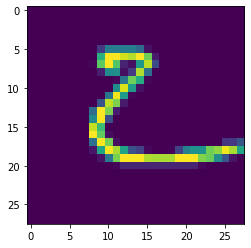

In [29]:

g = plt.imshow(X_train[0][:,:,0])

Building the Model

In [32]:
class Model:
    def __init__(self,X_train,X_val,y_train,y_val):
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
    def CNN(self,epochs=30,batch_size=86,report=True):
        model = Sequential()
        model.add(Conv2D(filters=32,
                        kernel_size=(5,5),
                        padding='Same',
                        activation='relu',
                        input_shape=(28,28,1)
                        ))
        model.add(Conv2D(filters=32,
                        kernel_size=(5,5),
                        padding='Same',
                        activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(10,activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-08,decay=0.8),
            loss="categorical_crossentropy",
            metrics=['accuracy']
        )

        learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',
                                                patience=3,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)

        history = model.fit(self.X_train,self.y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(self.X_val,self.y_val),verbose=2)

        '''for fitting datagen
        history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                                    epochs=epochs,
                                                    validation_data=(X_val,y_val),
                                                    verbose=2,
                                                    steps_per_epoch=X_train.shape[0]//batch_size,
                                                    callbacks=[learning_rate_reduction])
        '''
        y_pred = model.predict(self.X_val)

        if report is True:
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
        print(model.summary())
    


391/391 - 65s - loss: 0.9439 - accuracy: 0.7217 - val_loss: 0.6417 - val_accuracy: 0.8386 - 65s/epoch - 167ms/step
263/263 [==============================] - 2s 9ms/step


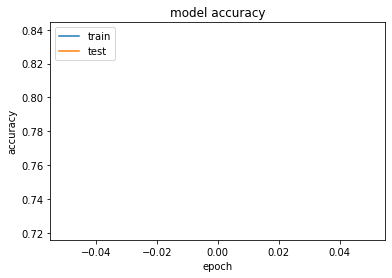

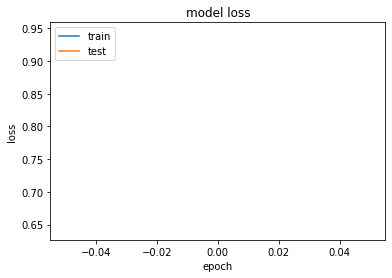

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               1605888   
                                                      

In [35]:
model1 = Model(X_train,X_val,y_train,y_val)
model1.CNN()

Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift=range=0.1,
    height_shift_range=0.1,
    horizonzal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)